In [1]:
import numpy as np
import math
import operator
import networkx as nx
from networkx.algorithms import approximation as approx
from itertools import permutations
import matplotlib.pyplot as plt
from deap import creator, base, tools, algorithms,gp
import dimod
import dwave_networkx as dnx
import import_ipynb
import tsp_parser
from tsp_parser import read_tsp_file
from operator import itemgetter
import pygraphviz as pgv
from IPython.display import Image 
import copy
import pickle
from tqdm import tqdm
import tsplib95
import tspsolve

importing Jupyter notebook from tsp_parser.ipynb
importing Jupyter notebook from city.ipynb


In [2]:
tsp = read_tsp_file('./symmetric_problems/berlin52.tsp')

In [3]:
problem = tsplib95.load('./symmetric_problems/berlin52.tsp')
# problem = tsplib95.load('./symmetric_problems/berlin52.tsp')
G = problem.get_graph()
# tsp_problem = problem.as_keyword_dict()
# list(problem.get_nodes())

In [4]:
distance_matrix = nx.to_numpy_matrix(G)

In [5]:
problem.is_complete()

True

In [6]:
def DrawGraph(G,color):
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels = True, edge_color = color)  #with_labels=true is to show the node number in the output graph
    edge_labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels,  font_size = 11) #prints weight on all the edges
    return pos

In [7]:
def distance(A, B): 
    "The Euclidean distance between two cities."
    return math.sqrt( ((A[0]-B[0])**2)+((A[1]-B[1])**2) )

In [8]:
def total_distance(G):
    total =0
    for edge in G.edges: 
        total += distance(G.nodes[edge[0]]["pos"],G.nodes[edge[1]]["pos"])
    return total

In [9]:
def shortest_path(G,P):
    total =0
    for index in range(len(P)-1): 
        total += distance(G.nodes[P[index]]["pos"],G.nodes[P[index +1]]["pos"])
    return total

In [10]:
def create_graph(cities):
    G = nx.Graph()  
    G=nx.complete_graph(len(cities))
    for index,city in enumerate(cities):
        G.nodes[index]['pos'] = (city.x,city.y)
    nx.set_edge_attributes(G, values = 1, name = 'weight')
    
    return G
    

In [11]:
G = create_graph(tsp['CITIES'])

In [12]:
def create_tour(individual):
    G = create_graph(tsp['CITIES'])
    G.clear_edges()
    for index,city in enumerate(tsp['CITIES']):
        G.nodes[index]['pos'] = (city.x,city.y)
        
    for index in range(len(individual)-1):
        G.add_edge(individual[index],individual[index+1])
    G.add_edge(individual[len(individual)-1],individual[0])
    
    return G

In [13]:
def evaluation(individual):
    return (total_distance(create_tour(individual)),)

In [14]:
def GraphCentroid(G):
    x = [G.nodes[p]['pos'][0] for p in G.nodes]
    y = [G.nodes[p]['pos'][1] for p in G.nodes]
    centroid = (sum(x) / len(G.nodes), sum(y) / len(G.nodes))
    return centroid

In [15]:
def GraphStd(G):
    x = [G.nodes[p]['pos'][0] for p in G.nodes]
    y = [G.nodes[p]['pos'][1] for p in G.nodes]
    return np.std([x,y],axis=0)

### GENETIC PROGRAMMING

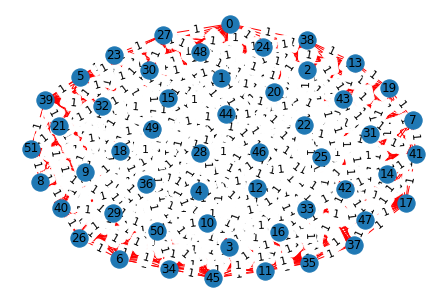

In [16]:
pos = DrawGraph(G,'red')

In [17]:
def plotGraph(G,show_weights=False):
    
    color_map = []
    node_sizes = []
    for node in G:
        if node == "center":
            color_map.append('red')
            node_sizes.append(800)
            
        else: 
            color_map.append('#6b61f4')
            node_sizes.append(300)

        
    pos=nx.get_node_attributes(G,'pos')
    nx.draw(G,pos,node_color=color_map,node_size = node_sizes,with_labels=True)
    labels = nx.get_edge_attributes(G,'weight')
    if show_weights:
        nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

    plt.show()

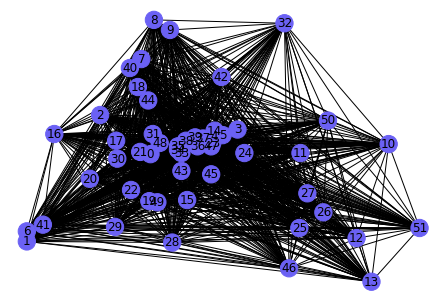

In [18]:
plotGraph(G)

In [19]:
print(total_distance(G))

762799.3942916737


In [20]:
def Div(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1

In [21]:
def Mod(left, right):
    try:
        return left % right
    except ZeroDivisionError:
        return 1

In [22]:
pset = gp.PrimitiveSet("MAIN",6)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(Div, 2)
pset.addPrimitive(Mod, 2)
#Number of nodes in the graph
pset.renameArguments(ARG0="Nn")
#Number of remaining nodes to visit
pset.renameArguments(ARG1="Nrn")
#Distance from the current node
pset.renameArguments(ARG2="Dcn")
#Distance from the initial node
pset.renameArguments(ARG3="Din")
#Distance from the centroid of the nodes
pset.renameArguments(ARG4="Dc")
#Predicted distance from the initial node
pset.renameArguments(ARG5="Pd")
# #Distance left estimation
# pset.renameArguments(ARG0="Dle")

In [23]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

In [24]:
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

In [25]:
def euc_distance(A, B): 
    return math.sqrt( ((A[0]-B[0])**2)+((A[1]-B[1])**2))

In [26]:
def nearest_neighbor(current,unvisited_nodes, G):
    min_node = min(unvisited_nodes, key=lambda x: euc_distance(G.nodes[x]["pos"], G.nodes[current]['pos']))
    return min_node

In [27]:
def greedy_TSP(G,visited):
    vis = visited
    while len(vis) < len(G.nodes):
        C = nearest_neighbor(vis[-1], np.setdiff1d(list(G.nodes),vis),G)
        vis.append(C)
#     vis.append(vis[0])
    score = evaluation(vis)[0]
    return vis,score

In [28]:
%%time
route,score = greedy_TSP(G,[0])

CPU times: user 11.7 ms, sys: 1.99 ms, total: 13.7 ms
Wall time: 12 ms


In [29]:
score

8980.91827932919

In [30]:
def pred_shortest_path(G,visited,node):
    unvisited_nodes = np.setdiff1d(list(G.nodes),visited).tolist()
    unvisited_nodes.insert(0,0)
    sub_G = G.subgraph(unvisited_nodes)
    return shortest_path(G,nx.shortest_path(sub_G,source=node,target=0))
    #return sub_G

In [31]:
def evaluate(individual,G):
#     G.clear_edges()
    tree = gp.PrimitiveTree(individual)
    
    node_results = [0]
    current_node = 0
    initial_node =0
    visited = [0]
    solution = [0]
    unvisited = np.setdiff1d(list(G.nodes),visited)
    while len(unvisited) > 1:
        results = []
        for index,node in enumerate(unvisited):
            if index not in visited:
                Nn = len(G.nodes())
                Nrn = len(np.setdiff1d(list(G.nodes),visited))
                Dcn = distance(G.nodes[current_node]["pos"],G.nodes[node]["pos"])
                Din = distance(G.nodes[initial_node]["pos"],G.nodes[node]["pos"])
                Dc = distance(GraphCentroid(G),G.nodes[node]["pos"])
#                Pd = greedy_TSP(G,visited)
                #Pd = shortest_path(G,nx.shortest_path(G,source=node,target=0))
                Pd = pred_shortest_path(G,visited,node)
                result = toolbox.compile(expr=individual)
                results.append({"result": result(Nn,Nrn,Dcn,Din,Dc,Pd),"node":node})
        if not results:
            break
        nearest = min(results, key=lambda x:x['result'])
        solution.append(nearest["node"])
        current_node = nearest["node"]
        visited.append(nearest["node"])
        unvisited = np.setdiff1d(list(G.nodes),visited)

    solution.append(initial_node)
    return shortest_path(G,solution),

In [32]:
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=2, max_=3)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)
toolbox.register("evaluate", evaluate, G= G)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

In [33]:
%%time
evaluate(toolbox.individual(),G)

CPU times: user 256 ms, sys: 4.43 ms, total: 260 ms
Wall time: 257 ms


(23744.742489698292,)

In [34]:
fit_stats = tools.Statistics(key=operator.attrgetter("fitness.values"))
fit_stats.register('mean', np.mean)
fit_stats.register('min', np.min)

In [35]:
pop = toolbox.population(n=50)
pop, log = algorithms.eaSimple(pop, toolbox,
                                 cxpb=0.8, mutpb=0.2,
                                 ngen=20,stats=fit_stats,verbose=True)

gen	nevals	mean   	min    
0  	50    	21678.8	11805.9
1  	41    	18839.4	11805.9
2  	44    	16995.5	11534.5
3  	48    	15487.7	11534.5
4  	35    	16151.5	11534.5
5  	44    	15620.8	11534.5
6  	38    	15956.6	11631.6
7  	43    	15895.9	10472  
8  	47    	16991.6	11534.5
9  	49    	16455  	11178.4
10 	48    	13787.5	11178.4
11 	45    	14030.2	11178.4
12 	47    	14880.6	11106  
13 	36    	13788.4	10857.2
14 	41    	13615.6	10423.1
15 	42    	13419  	10423.1
16 	40    	13704  	10423.1
17 	36    	12030.9	10407.6
18 	42    	12796.2	10407.6
19 	42    	12703.6	10407.6
20 	39    	12221.6	9388.74


In [ ]:
%%time
min_results =[]
mean_results = []
for index in tqdm(range(10)):
    pop = toolbox.population(n=50)
    pop, log = algorithms.eaSimple(pop, toolbox,
                                 cxpb=0.8, mutpb=0.2,
                                 ngen=20,stats=fit_stats,verbose=True)
    min_results.append(np.min(log.select('min')))
    mean_results.append(np.min(log.select('mean')))

8


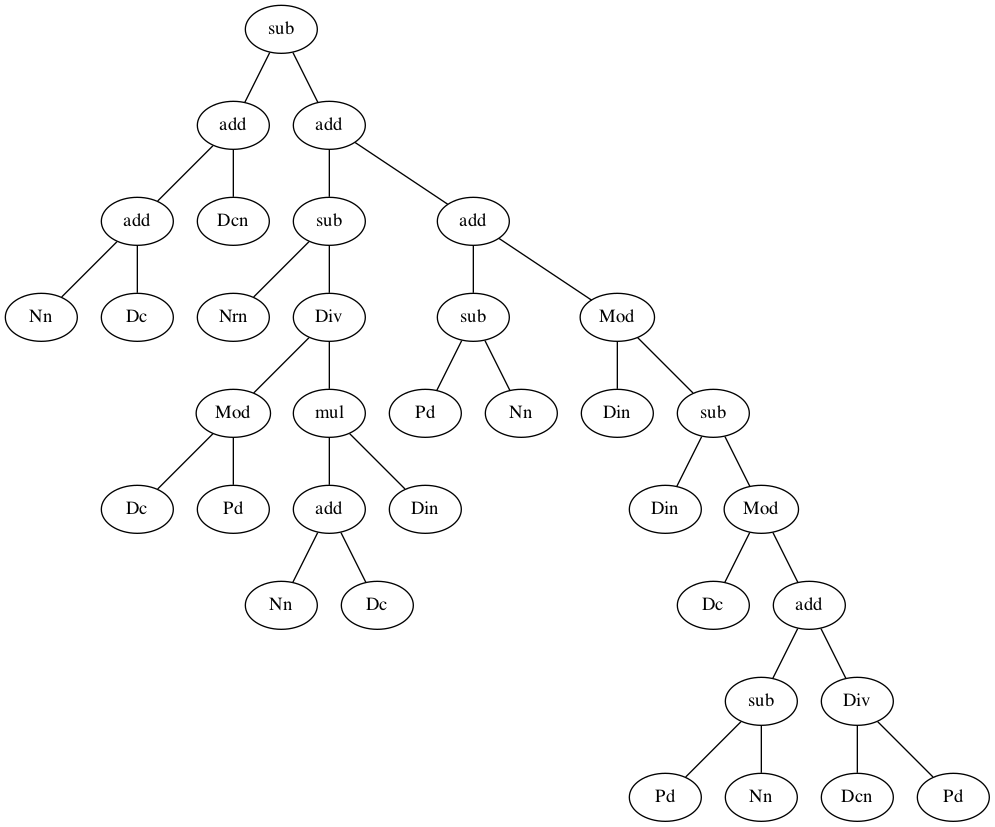

In [36]:
best_individual = tools.selBest(pop, k=1)[0]
print(best_individual.height)
nodes, edges, labels = gp.graph(best_individual)
# print('Fitness of the best individual: ', evaluation(best_individual)[0])

g = pgv.AGraph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)
g.layout(prog="dot")

for i in nodes:
    n = g.get_node(i)
    n.attr["label"] = labels[i]

g.draw("./figures/tree.png")

pil_img = Image(filename='./figures/tree.png')
display(pil_img)

In [ ]:
plt.figure(figsize=(11, 4))
plt.plot(log.select('mean'),label="mean")
plt.plot(log.select('min'),label="min")
plt.legend()
plt.ylabel('Fitness'); plt.xlabel('Iterations');
plt.title("eil51 symmetric mean training runs")
# plt.savefig("./figures/berlin52_50_gens_50.png", bbox_inches = 'tight',
#     pad_inches = 0)

In [ ]:
tree = gp.PrimitiveTree(pop[1]) 
string_tree = str(tree)
print(string_tree)

In [ ]:
mean_distance = np.mean(min_results)
min_distance = np.min(min_results)
std_distance = np.std(min_results)

In [ ]:
print("scores,mean:{},min:{},std:{}".format(mean_distance,min_distance,std_distance))